In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn import metrics

from diffusion_functions import *
from semi_supervised_manifold_learning import *
from yelp_restaurant_clustering import *
from animate_diffusion import animate_diffusion

# commands for displaying animations in jupyter notebook
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

# Instance illustration

Currently using threshold around 0

In [2]:
def plot_label_comparison_binary(ax, label_vector, data_matrix, titlestring=None):
    error, threshold = find_min_sweepcut(label_vector,100,sweep_cut_classification_error)
    #threshold = 0
    label_estimates = make_sweep_cut(label_vector, threshold)
    error = sweep_cut_classification_error(label_estimates)
    
    community_size = int(len(label_vector)/2)
    im = ax.scatter(data_matrix[:,0],data_matrix[:,1], c=label_estimates)
    #im = ax.scatter(data_matrix[:community_size,0],data_matrix[:community_size,1], c=label_estimates[:community_size])
    #plt.colorbar(im, ax=ax)
    
    # figure formatting
    ax.set_aspect('equal')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axis('off')
    if titlestring=='Abridged':
        ax.set_title(f'Classification error = {error:.3f}', fontsize = 15)
    else:
        ax.set_title(titlestring +f'\n Classification error = {error:.3f}', fontsize = 15)
    return

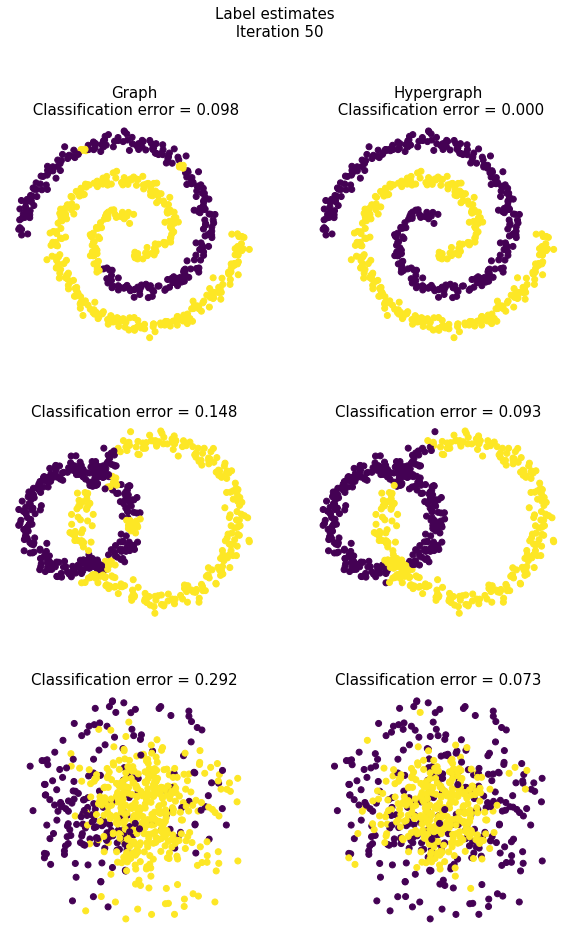

In [3]:
k = 5
target_iternum = 50
diffusion_step_size = 1
titlestring = 'blah'

fig_binary, ax_binary = plt.subplots(nrows=3, ncols=2,figsize=(10, 15))
problem_index = 0
for data_generation, problem_kind in [(generate_spirals,' Spirals'), (generate_overlapping_rings,' Rings'),
                                      (generate_concentric_highdim,' Concentric Highdim')]:
    
    graph_x, hypergraph_x, data_matrix = compare_estimated_labels(data_generation,k,target_iternum,
                        diffusion_step_size,titlestring=None)

    for idx,(x,titlestring) in enumerate([(graph_x[-1],'Graph'), (hypergraph_x[-1],'Hypergraph')]):
        if problem_index==0:
            plot_label_comparison_binary(ax_binary[problem_index, idx],x, data_matrix,titlestring)
        else:
            plot_label_comparison_binary(ax_binary[problem_index, idx],x, data_matrix,titlestring = 'Abridged')
    problem_index+=1
    
plt.suptitle(f'Label estimates \n Iteration {target_iternum}', fontsize = 15)    
#plt.savefig('estimated_labels_example.pdf', bbox_inches='tight')
plt.show()

# AUC Histogram

In [3]:
def plot_AUC_hist(AUC_vals, axes, abridged = True):
    plt.rcParams.update({'font.size': 15})
    if abridged:
        titlestring = f'Iteration {max_iterations_needed}, over {num_trials} trials'
    else:
        titlestring = f'Iteration {max_iterations_needed}, over {num_trials} trials'
        
    # first style
    _, first_bins, _ = axes[0].hist([[v[1] for v in AUC_vals], [v[0] for v in AUC_vals]], edgecolor = 'black', label=['graph', 'hypergraph'])
    axes[0].legend()
    axes[0].set_title(titlestring)

    # second style
    axes[1].hist([v[1] for v in AUC_vals], bins = first_bins, alpha=0.5, edgecolor = 'black', label = 'graph')
    axes[1].hist([v[0] for v in AUC_vals], bins = first_bins, alpha=0.5, edgecolor = 'black', label='hypergraph')
    axes[1].legend()
    axes[1].set_title(titlestring)
    
    # figure formatting
    for ax in axes:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
    return


def final_plot_AUC_hist(AUC_vals, ax, decorated = False):
    plt.rcParams.update({'font.size': 15})
        
    hypergraph_vals = [v[0] for v in AUC_vals]
    graph_vals = [v[1] for v in AUC_vals]
    
    full_values = hypergraph_vals+graph_vals
    _, first_bins = np.histogram(full_values, bins = 10)

    # second style
    ax.hist(graph_vals, bins = first_bins, alpha=0.5, edgecolor = 'black', label = 'graph')
    ax.hist(hypergraph_vals, bins = first_bins, alpha=0.5, edgecolor = 'black', label='hypergraph')
    
    if decorated:
        ax.set_title(f'AUC Values at Iteration 50 \n Results from 50 Independent Trials')
        ax.legend()
        
    # figure formatting
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    return

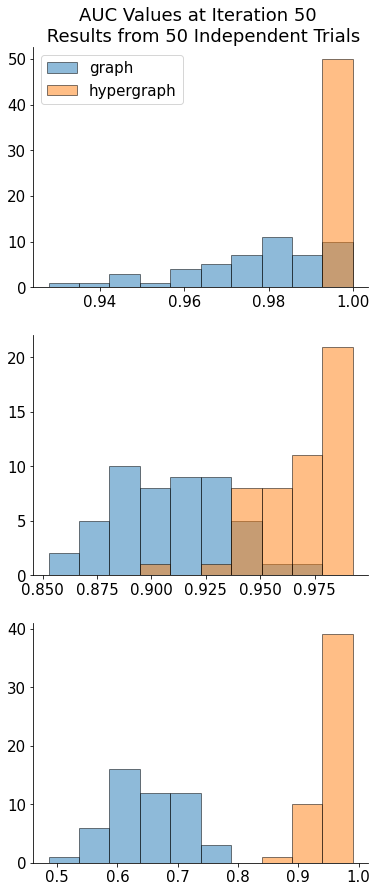

In [4]:
k = 5
iterations_to_plot = [50]
diffusion_step_size = 1
num_trials = 50

#fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (12, 15))
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (6, 15))
axes_idx = 0

for data_generation, problem_kind in [(generate_spirals,'Spirals'), (generate_overlapping_rings,'Rings'),
                                      (generate_concentric_highdim,'Concentric hyperspheres')]:
    AUC_vals = []
    for trial in range(num_trials):
        # generate new data
        _,data_matrix = data_generation(verbose=False)

        # build graph/hypergraph
        knn_adj_matrix = build_knn_graph(data_matrix,k)
        knn_hgraph_dict = build_knn_hypergraph(data_matrix,k)

        # run diffusion
        max_iterations_needed = max(iterations_to_plot)
        hypergraph_diff_results, graph_diff_results = semi_superivsed_knn_clustering(knn_adj_matrix,
                        knn_hgraph_dict, num_iterations = max_iterations_needed, verbose = False)

        hypergraph_x = hypergraph_diff_results['x']
        graph_x = graph_diff_results['x']

        n = data_matrix.shape[0]
        labels = np.hstack([np.full(shape=int(n/2),fill_value = -1),np.full(shape=int(n/2),fill_value = 1)])
        graph_auc_score = metrics.roc_auc_score(labels, graph_x[-1, :])
        hypergraph_auc_score = metrics.roc_auc_score(labels, hypergraph_x[-1, :])

        AUC_vals.append((hypergraph_auc_score, graph_auc_score))
    final_plot_AUC_hist(AUC_vals, ax = ax[axes_idx], decorated = (axes_idx == 0) )
    axes_idx+=1
#plt.savefig('AUC_hist.pdf', bbox_inches='tight')
plt.show()
    

# Error by iteration

In [ ]:
def plot_error_vs_iteration(ax,index,diffusion_iterations, 
                            graph_error_vs_iteration, hypergraph_error_vs_iteration):
    plt.rcParams.update({'font.size': 15})
    
    iterations = np.arange(0,diffusion_iterations)
    plotting_label = ['graph','hypergraph']
    plotting_color = ['b','o']
    for idx,error_array in enumerate([np.array(graph_error_vs_iteration), np.array(hypergraph_error_vs_iteration)]):
        mean_error_by_iteration = np.mean(error_array,axis=0)
        std_error_by_iteration = np.std(error_array,axis=0)

        ax.plot(iterations, mean_error_by_iteration,label = plotting_label[idx])
        ax.fill_between(iterations, mean_error_by_iteration-std_error_by_iteration, mean_error_by_iteration+std_error_by_iteration,alpha = 0.5)
    # figure formatting
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if index==0:
        ax.legend()
        ax.set_title('Error versus iteration number', fontsize = 17)
    ax.set_ylabel('Error', fontsize = 17)
    ax.set_ylim(0,0.5)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    if index==2:
        ax.set_xlabel('Iteration number', fontsize = 16)
    return
        

In [ ]:
k = 5
diffusion_iterations = 40
diffusion_step_size = 1
num_trials = 20
titlestring = 'blah'

fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(10, 15))
idx = 0
for data_generation, problem_kind in [(generate_spirals,' Spirals'), (generate_overlapping_rings,' Rings'),
                                      (generate_concentric_circles,' Concentric')]:
    graph_error_vs_iteration, hypergraph_error_vs_iteration = repeated_clustering_experiments(data_generation,k,
                                        diffusion_iterations,diffusion_step_size,num_trials,problem_kind)
    plot_error_vs_iteration(ax[idx],idx,diffusion_iterations, 
                            graph_error_vs_iteration, hypergraph_error_vs_iteration)
    idx+=1

#plt.savefig('error_vs_iteration.pdf', bbox_inches='tight')
plt.show()
